In [1]:
# only adjust settings in this cell
state = 'ME' 
year = 2020
enumeration_limit = 10

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json
from epsilon_constraint import*
import networkx as nx

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of ME has 2 districts.


In [5]:
from optimization import iterative_refinement
from math import ceil, floor
from metrics import *
import time

deviation = 1/2
max_deviation = 0.01 * ideal_population
plans = list()
first_feasible_dev = None

while True:

    print("*****************************************")
    print(f"Trying deviation = {deviation}.")
    print("*****************************************")
    
    L = ceil( ideal_population - deviation )
    U = floor( ideal_population + deviation )

    start_time = time.perf_counter()
    new_plans = iterative_refinement(G, L, U, G._k, state, enumeration_limit=enumeration_limit, verbose=False)
    print("Total time =",round(time.perf_counter() - start_time,2))
    
    if new_plans:
        plans += new_plans
        if first_feasible_dev is None:
            min_observed_dev = min(observed_deviation_persons(G, plan, ideal_population) for plan in new_plans)
            first_feasible_dev = min_observed_dev
            

    if deviation == max_deviation:
        break
    
    deviation *= 2
    deviation = min( deviation, max_deviation )
       

*****************************************
Trying deviation = 0.5.
*****************************************
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
Total time = 0.96
*****************************************
Trying deviation = 1.0.
*****************************************
Total time = 0.0
*****************************************
Trying deviation = 2.0.
*****************************************
Total time = 0.51
*****************************************
Trying deviation = 4.0.
*****************************************
Total time = 0.58
*****************************************
Trying deviation = 8.0.
*****************************************
Total time = 0.64
*****************************************
Trying deviation = 16.0.
*****************************************
Total time = 0.37
*****************************************
Trying deviation = 32.0.
*****************************************
Tot

In [6]:
infeasible_region = [0, first_feasible_dev] if first_feasible_dev > 0.5 else None
print(f"Infeasible region is: {infeasible_region}")

Infeasible region is: [0, 750.5]


***************************************
obj_type = cut_edges
***************************************
Pareto front objective values: [[750.5, 15], [1483.5, 14], [1882.5, 11], [2777.5, 5]]


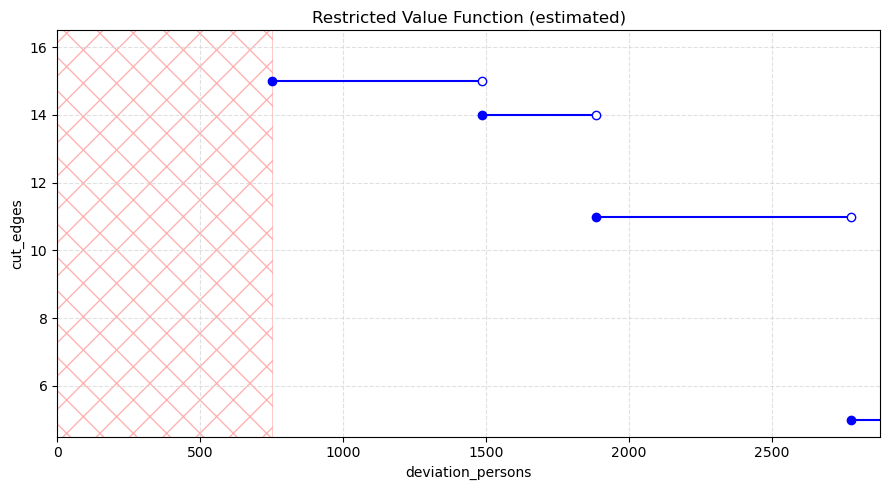

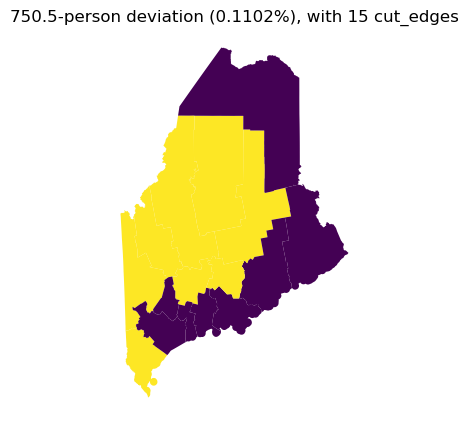

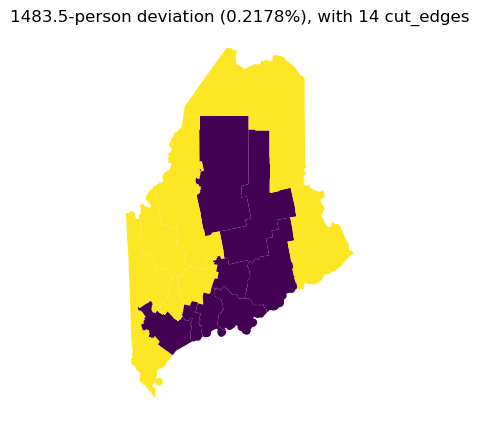

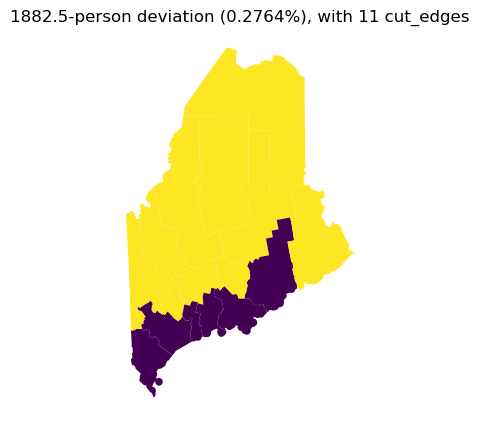

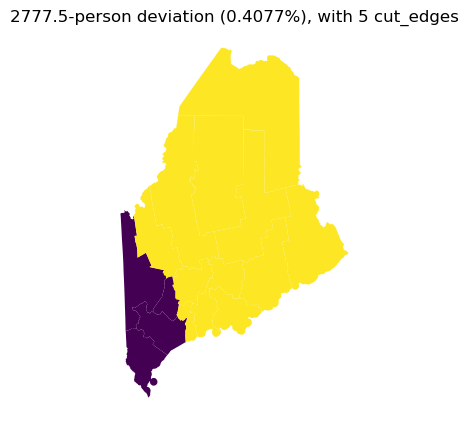

***************************************
obj_type = perimeter
***************************************
Pareto front objective values: [[750.5, 37.022377125354154], [1882.5, 30.979980713874923], [2777.5, 23.733763883955692]]


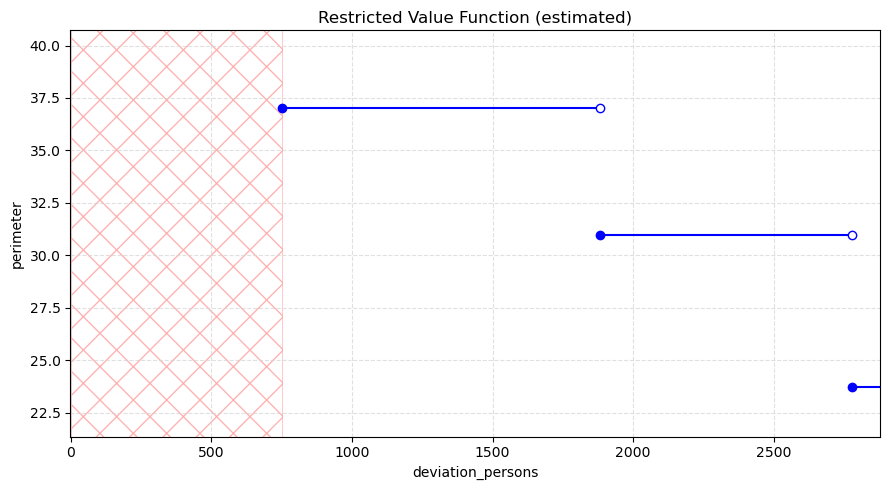

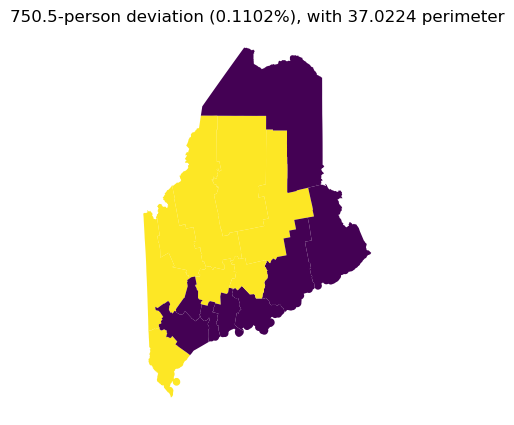

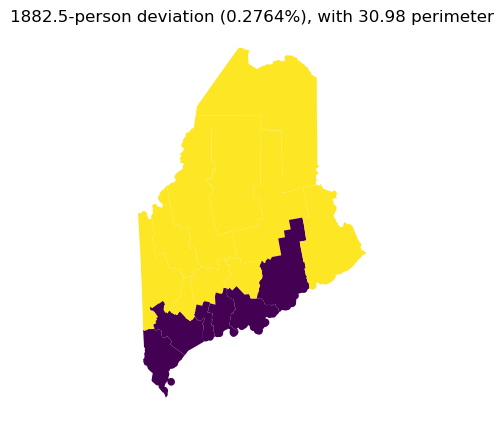

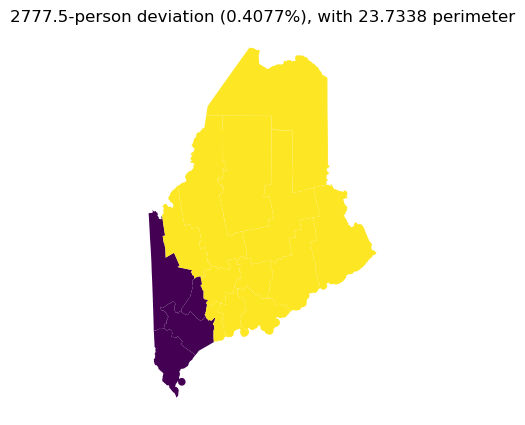

***************************************
obj_type = inverse_Polsby_Popper
***************************************
Pareto front objective values: [[750.5, 6.126891015162613], [1882.5, 5.047485703140486], [2777.5, 3.094050204160066]]


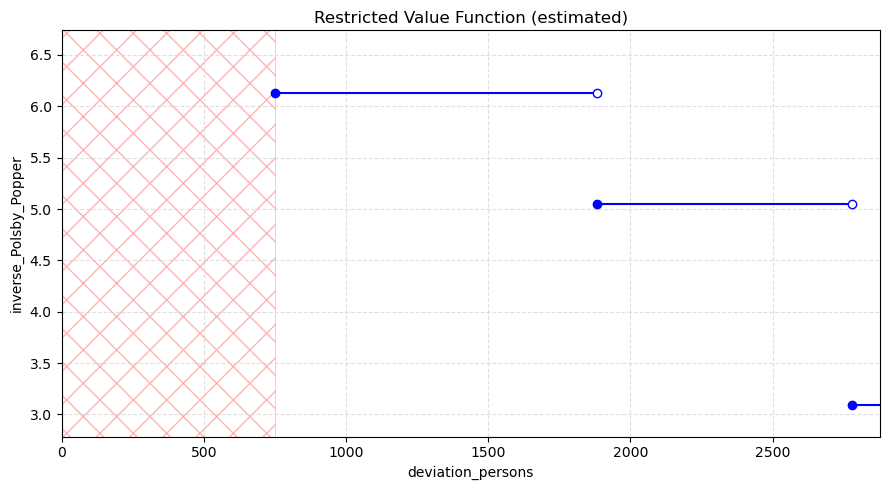

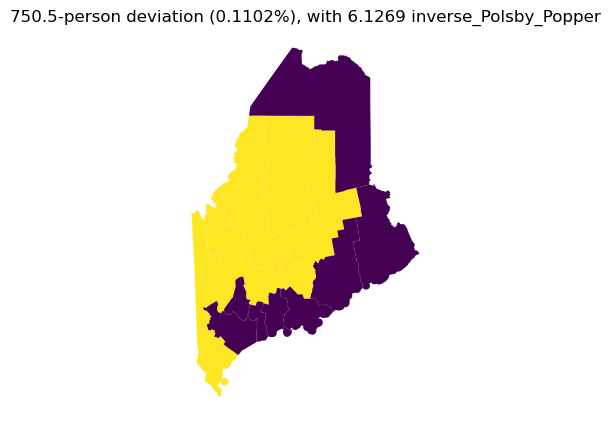

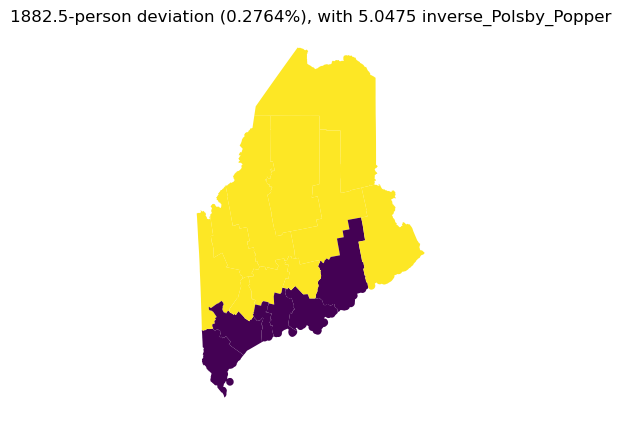

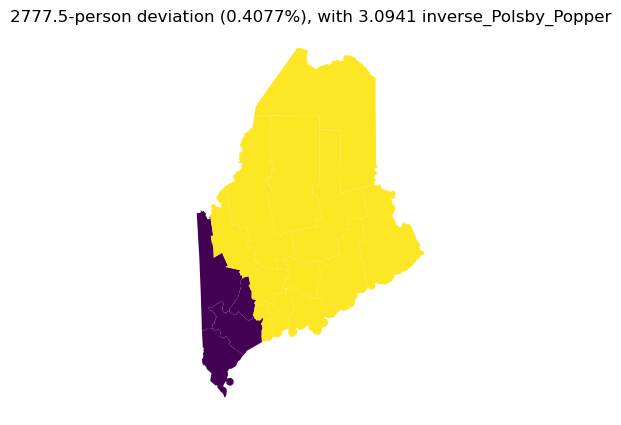

***************************************
obj_type = average_Polsby_Popper
***************************************
Pareto front objective values: [[750.5, 0.17519573386852202], [1882.5, 0.20765187988935258], [2777.5, 0.33204492607301983]]


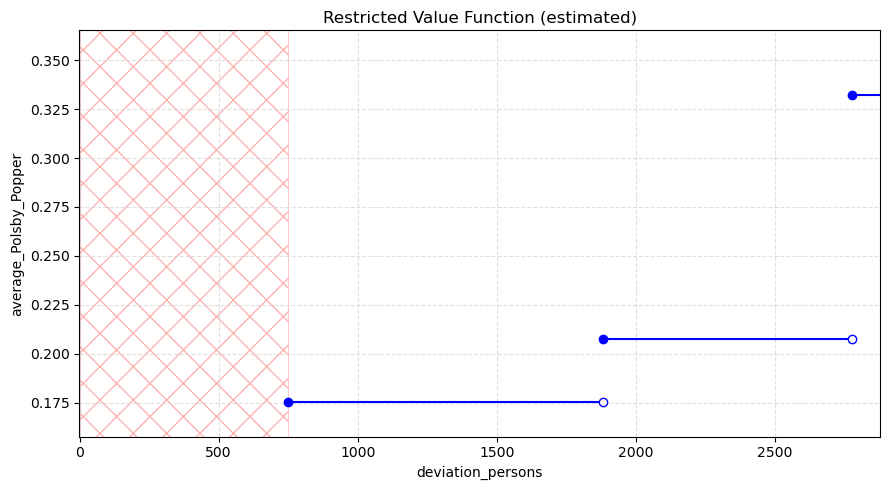

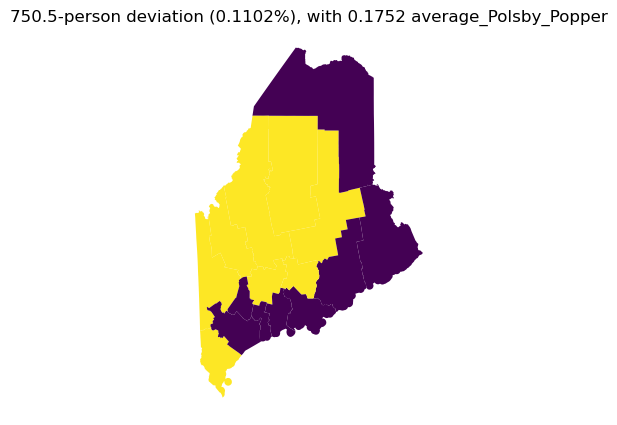

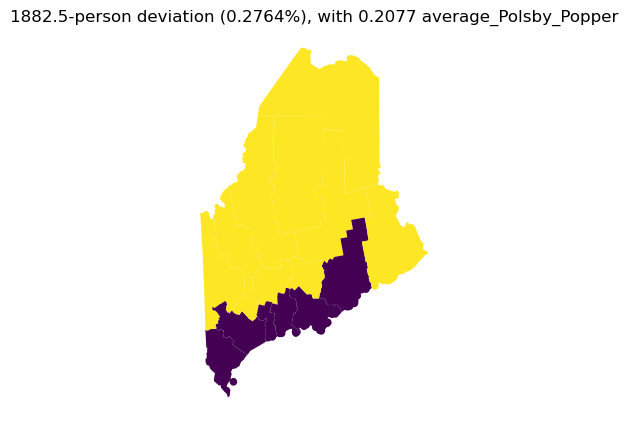

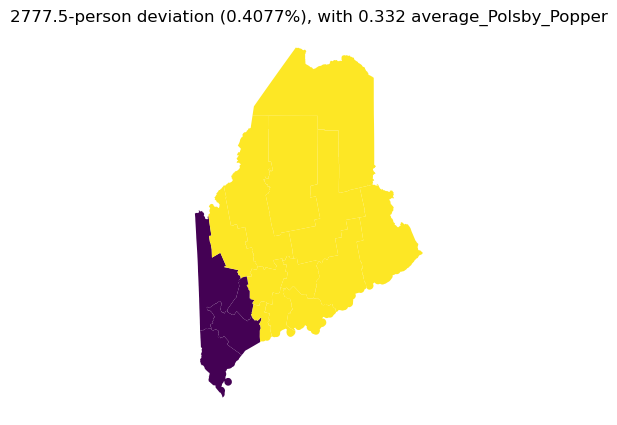

***************************************
obj_type = bottleneck_Polsby_Popper
***************************************
Pareto front objective values: [[750.5, 0.12938101738023425], [1882.5, 0.16315877430560258], [2777.5, 0.2778545795073467]]


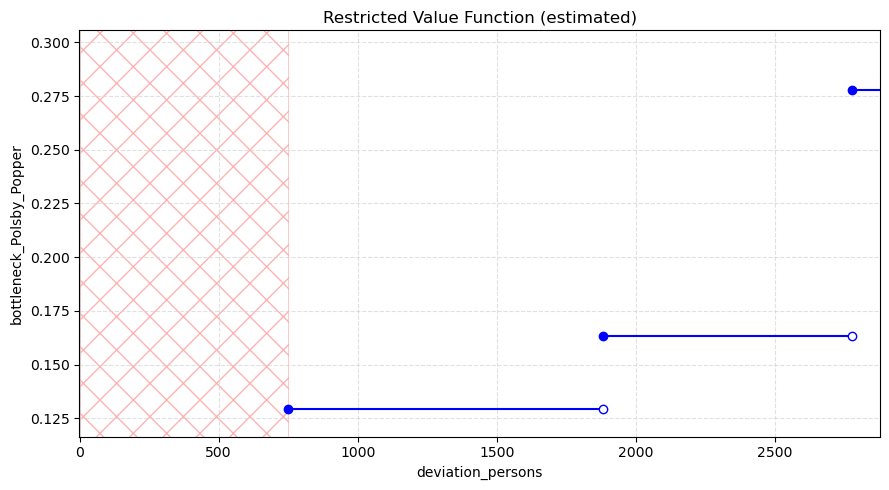

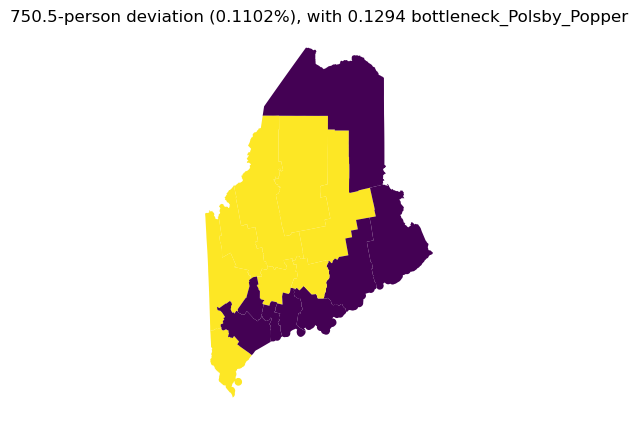

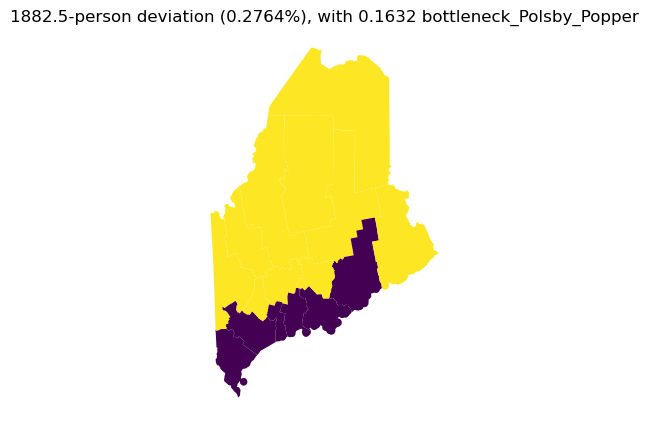

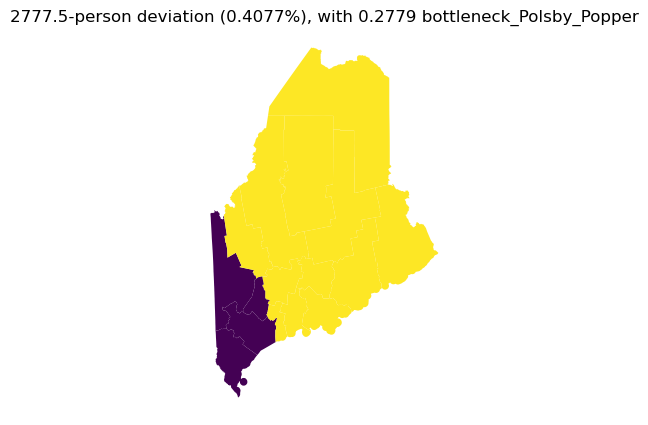

In [7]:
from pareto import ParetoFrontier
from draw import draw_plan

# set dummy values... (because compute_obj checks plan feasibility...)
G._L = 0 
G._U = G._k * ideal_population
pareto = dict()

obj_types = ['cut_edges', 'perimeter', 'inverse_Polsby_Popper', 'average_Polsby_Popper', 'bottleneck_Polsby_Popper']

for obj_type in obj_types:

    print("***************************************")
    print("obj_type =", obj_type)
    print("***************************************")
    
    senses = ['min', 'max' if obj_type in ['average_Polsby_Popper', 'bottleneck_Polsby_Popper'] else 'min']
    obj_names = ['deviation_persons', obj_type]
    pareto[obj_type] = ParetoFrontier(senses, obj_names, state=state, level='county')
    
    for plan in plans:  
        dev = observed_deviation_persons(G, plan, ideal_population)
        obj = compute_obj(G, plan, obj_type)
        objs_val = [dev, obj]
        pareto[obj_type].add_plan(plan, upper_bound=objs_val)

    print("Pareto front objective values:", pareto[obj_type].upper_bounds)
    if infeasible_region is not None and infeasible_region[1] > 0.5:
        upper_bounds = pareto[obj_type].upper_bounds
        max_dev = max(upper_bound[0] for upper_bound in upper_bounds)
        max_obj = max(upper_bound[1] for upper_bound in upper_bounds)
        min_obj = min(upper_bound[1] for upper_bound in upper_bounds)
        o1lim=[-1, max_dev+100]
        o2lim=[min_obj*0.9, max_obj*(1.1)]
    else:
        o1lim = None
        o2lim = None
    
    pareto[obj_type].tighten_lower_bounds()       
    pareto[obj_type].plot_with_custom_x_ranges(method ='heuristic', splits=None,
                                              o1lim=o1lim, o2lim=o2lim, infeasible_region = infeasible_region)    
    pareto[obj_type].draw_plans()

In [8]:
len(plans)

18

In [9]:
for obj_type in obj_types:

    print("***************************************")
    print("obj_type =", obj_type)
    print("***************************************")
    print("Pareto front plans:", pareto[obj_type].plans)

***************************************
obj_type = cut_edges
***************************************
Pareto front plans: [[[5, 6, 7, 8, 10, 12, 13, 14], [0, 1, 2, 3, 4, 9, 11, 15]], [[1, 4, 5, 6, 7, 8, 13, 15], [0, 2, 3, 9, 10, 11, 12, 14]], [[0, 5, 6, 7, 8, 13], [1, 2, 3, 4, 9, 10, 11, 12, 14, 15]], [[0, 3, 6, 12], [1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15]]]
***************************************
obj_type = perimeter
***************************************
Pareto front plans: [[[5, 6, 7, 8, 10, 12, 13, 14], [0, 1, 2, 3, 4, 9, 11, 15]], [[0, 5, 6, 7, 8, 13], [1, 2, 3, 4, 9, 10, 11, 12, 14, 15]], [[0, 3, 6, 12], [1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15]]]
***************************************
obj_type = inverse_Polsby_Popper
***************************************
Pareto front plans: [[[5, 6, 7, 8, 10, 12, 13, 14], [0, 1, 2, 3, 4, 9, 11, 15]], [[0, 5, 6, 7, 8, 13], [1, 2, 3, 4, 9, 10, 11, 12, 14, 15]], [[0, 3, 6, 12], [1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15]]]
**********************